# Intro

In this example, we look at how you can use fiberorient to estimate the local orientations of structures in 3D imaging data.

First, we load in some base packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

# Construct phantom

We'll demonstrate the structure tensor algorithm on a synthetic phantom consisting of a 3x2x1 grid of mega-voxels, each containing a bundle of differently oriented pseudo-tubes, constructed with overlapping sinusoids. The orientations of the structures within each mega-voxel are given by:

|  |  | |
| --- | ----------- | ---- |
| x | y | z |
| xy | xz | yz|

Where x, y, and z correspond to the first, second, and third dimensions of the array, respectively. 

In [2]:
def make_phantom(shape, d, P):
    '''Utility function to construct a phantom out of a grid of 
    mega-voxels with shape `shape`. Each mega-voxel is a cube of 
    size `d`^3, and `P` is the period of the sinusoids used to 
    construct the fiber bundles.
    '''
    nx, ny, nz = shape

    x, y, z = np.meshgrid(np.linspace(-nx/2, nx/2, nx),
                          np.linspace(-ny/2, ny/2, ny),
                          np.linspace(-nz/2, nz/2, nz),
                          indexing='ij')

    ks = np.zeros((nx//d, ny//d, 2, 3))
    ks[0, 0] = np.array([[0, 1, 0], [0, 0, 1]])  # x
    ks[1, 0] = np.array([[1, 0, 0], [0, 0, 1]])  # y
    ks[2, 0] = np.array([[1, 0, 0], [0, 1, 0]])  # z

    ks[0, 1] = np.array([[1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 1]])  # xy
    ks[1, 1] = np.array([[1/np.sqrt(2), 0, 1/np.sqrt(2)], [0, 1, 0]])  # xz
    ks[2, 1] = np.array([[0, 1/np.sqrt(2), 1/np.sqrt(2)], [1, 0, 0]])  # z

    phantom = np.zeros_like(x)
    for xx in range(nx//d):
        for yy in range(ny//d):
            k1, k2 = ks[xx, yy]
            wave = np.cos((2 * np.pi / P) * (k1[0] * x + k1[1] * y + k1[2] * z)) + np.cos(
                (2 * np.pi / P) * (k2[0] * x + k2[1] * y + k2[2] * z))
            sli = (slice(xx * d, (xx + 1) * d), slice(yy * d, (yy + 1) * d))
            phantom[sli] = wave[sli]

    return phantom

def plot_image(img,**kwargs):
    '''Utility function to plot 2D image'''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(img, interpolation='none',**kwargs)
    ax.axis('off')
    ax.set_aspect('equal')
    return fig, ax

For this demo, we'll construct a phantom with the following parameters and visualize an xy slice:

phantom.shape = (195, 130, 65)


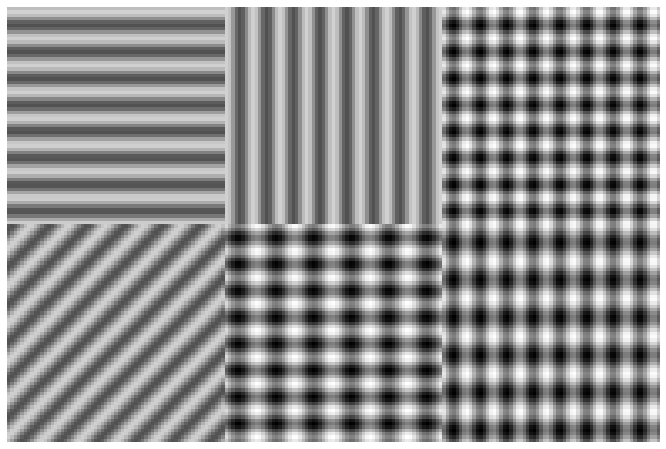

In [3]:
d = 65
shape = (d*3,d*2,d*1)
P = 8  
phantom = make_phantom(shape, d, P=P)
print(f'phantom.shape = {phantom.shape}')
plot_image(phantom[...,10].T,cmap='gray');

# Estimate orientations

Local orientations are estimated in fiberorient using the `StructureTensor` class. The `d_sigma` argument controls the width of the Gaussian derivative filter used to construct the structure tensor at each voxel. It should be tuned to be smaller than the estimated width of the structures of interest. It works together with `n_sigma` which is the width of the Gaussian filter used to define the local neighborhood and control for noise. 

In [4]:
from fiberorient import StructureTensor

st = StructureTensor(d_sigma=1,n_sigma=3,verbose=True)
st.fit(phantom);

Computing gradient
Imz
Imy
Imx
Forming ST elements:
Szz
Szy
Szx
Syy
Syx
Sxx


Once the `StructureTensor` has been fit, the voxel-wise array of 3x3 structure tensors is available as:

In [5]:
st.S.shape

(195, 130, 65, 3, 3)

The next step is to estimate local orientations from the structure tensors using the `get_vectors` method:

In [6]:
vectors = st.get_vectors(phantom)

Calculating eigenvectors/values
Done!


This returns an array of vectors at every voxel...

In [7]:
vectors.shape

(195, 130, 65, 3)

...as well as a confidence measure from 0-1 calculated from the eigenvalues of the structure tensors:

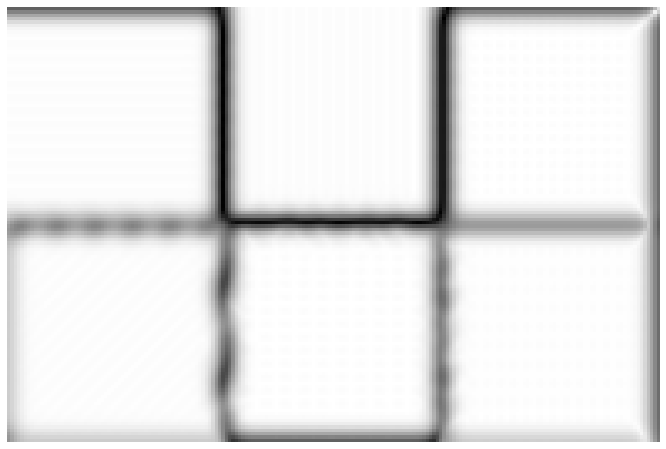

In [8]:
plot_image(st.confidence[...,10].T,cmap='gray');

As expected, we see generally very high confidence within the noiseless mega-voxels, but lower confidence along boundaries. Play around with the `d_sigma` and `n_sigma` parameters to see how it affects these low-confidence widths.

# Visualize vectors

fiberorient provides two utility functions for visualizing vector results. The first is `img_to_dec`, which takes in a scalar image and a vector image and produces an RGB color overlay image, where the intensity is proportional to the scalar image and the components of the vector are mapped to RGB as follows:

dimension 0: red

dimension 1: green

dimension 2: blue

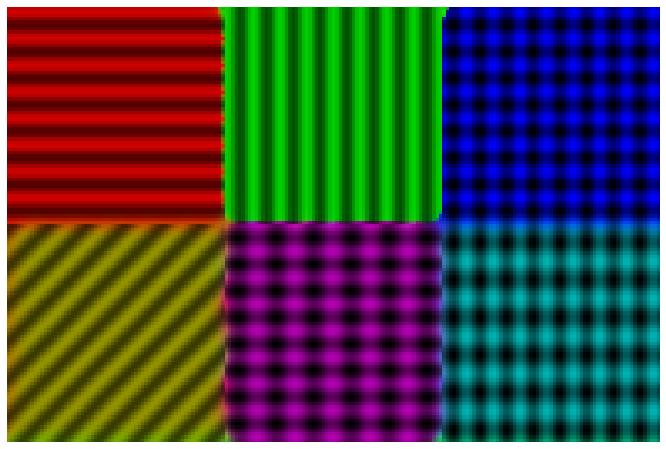

In [9]:
from fiberorient.vis import img_to_dec

dec = img_to_dec(phantom, vectors)
img = np.swapaxes(dec[...,10,:],0,1)
plot_image(img);

We observe different, relatively uniform colors within each mega-voxel, with colors that correspond to the observed orientations. 

We can also visualize the vectors as glyphs overlaying individual pixels with `show_vectors_2D`. This function uses fury, a wrapper for vtk. The result cannot be embedded in a notebook, so we save it to a png and load it back in for display with matplotlib:

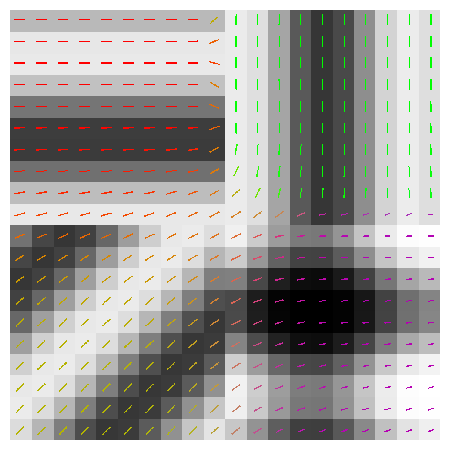

In [10]:
from fiberorient.vis import show_vectors_2D

# Works better on small arrays, demonstrating on a sub-image
# at the boundary of 4 mega-voxels

dx = 20
dy = 20

x0=d-dx//2
xf = d + dx//2
y0 = d-dy//2
yf = d+dy//2

img = phantom[x0:xf,y0:yf,10]
vecs = vectors[x0:xf,y0:yf,10,:]
out_path='st_demo.png'

show_vectors_2D(img,
                vecs,
                out_path=out_path,
                linewidth=3)
im = plt.imread(out_path)
plot_image(im,origin='lower');

# Save results

We will use these results in the next example

In [11]:
np.save('vectors.npy',vectors)
np.save('phantom.npy',phantom)